In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
import tensorflow as tf
from tensorflow.keras.layers import RNN, LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm

In [3]:
data="/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv"
df=pd.read_csv(data)

In [4]:
df.head(5)

,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [5]:
df.tail(5)

,label,content
329995,0,DOA: فتح العلامة التجارية الجديدة من Box.تم تث...
329996,0,شركة صعبة التعامل معها: المنتج كان على ما يرام...
329997,0,SDK Sansa Leather Case: فقير للغاية.لم يتم الإ...
329998,0,حسنًا ، لكن ليس رائعًا: حسنًا ، لقد اشتريت هذا...
329999,1,مريحة جدا!: هذه النعال رائعة!أنها ناعمة جدا وم...


In [6]:
df.isnull().sum()

label      0
content    0
dtype: int64

In [7]:
df.duplicated().sum()

32

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

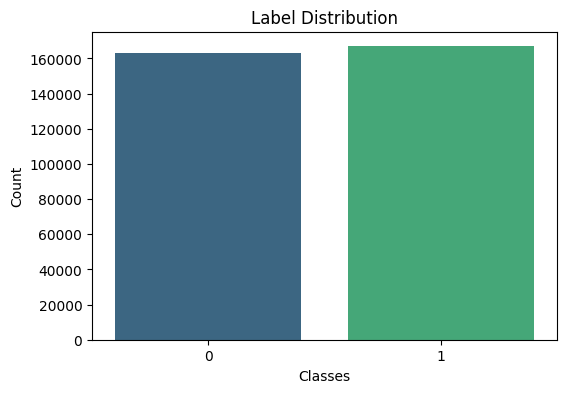

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [11]:
df.shape

(329968, 2)

In [12]:
# Split data 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.3, random_state=42)


In [13]:
# Preprocess text (tokenization using BERT tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
def encode_texts(texts, tokenizer, max_length=512):
    inputs = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    return inputs

train_inputs = encode_texts(X_train, tokenizer)
test_inputs = encode_texts(X_test, tokenizer)

# Prepare datasets for fine-tuning
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.inputs.items()}, self.labels.iloc[idx]

train_dataset = TextDataset(train_inputs, y_train)
test_dataset = TextDataset(test_inputs, y_test)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define BERT-based model for classification
class BertForSequenceClassification(nn.Module):
    def __init__(self, dropout=0.3):
        super(BertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)  # 2 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output
        output = self.dropout(pooler_output)
        return self.fc(output)

In [17]:
# Initialize BERT model for classification
model_bert = BertForSequenceClassification()

# Train and evaluate the BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

optimizer = torch.optim.Adam(model_bert.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
def train_model(model, train_loader, optimizer, criterion, device, patience=3):
    model.train()
    total_loss = 0
    best_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(10):  # Maximum number of epochs
        epoch_loss = 0
        for batch in tqdm(train_loader):
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return best_loss

In [24]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return classification_report(y_true, y_pred)

In [25]:
# Evaluate BERT model
print("Evaluating BERT Model:")
print(evaluate_model(model_bert, test_loader, device))

Evaluating BERT Model:


100%|██████████| 3094/3094 [51:16<00:00,  1.01it/s]

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     48812
           1       0.90      0.80      0.85     50179

    accuracy                           0.85     98991
   macro avg       0.86      0.85      0.85     98991
weighted avg       0.86      0.85      0.85     98991



In [26]:
# 2. RNN, LSTM, Bi-Directional RNN, and Bi-Directional LSTM models
def build_rnn_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        RNN(128, return_sequences=True),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
def build_lstm_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        LSTM(128, return_sequences=True),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
def build_bi_rnn_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        Bidirectional(RNN(128, return_sequences=True)),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bi_lstm_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
# Example usage:
input_dim = 10000  # Vocab size for tokenizer (this is an approximation)
output_dim = 2  # Number of classes

rnn_model = build_rnn_model(input_dim, output_dim)
lstm_model = build_lstm_model(input_dim, output_dim)
bi_rnn_model = build_bi_rnn_model(input_dim, output_dim)
bi_lstm_model = build_bi_lstm_model(input_dim, output_dim)

# Fine-tune models and evaluate with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

rnn_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
lstm_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
bi_rnn_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
bi_lstm_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


ValueError: Argument `cell` should have a `call` method. Received: cell=128

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Function to build an RNN model
def build_rnn_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(128),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build an LSTM model
def build_lstm_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        LSTM(128, return_sequences=True),
        LSTM(128),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build a Bi-Directional RNN model
def build_bi_rnn_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        Bidirectional(SimpleRNN(128, return_sequences=True)),
        Bidirectional(SimpleRNN(128)),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build a Bi-Directional LSTM model
def build_bi_lstm_model(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=512),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(128)),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage:
input_dim = 10000  # Vocab size for tokenizer (approximate)
output_dim = 2  # Number of classes

rnn_model = build_rnn_model(input_dim, output_dim)
lstm_model = build_lstm_model(input_dim, output_dim)
bi_rnn_model = build_bi_rnn_model(input_dim, output_dim)
bi_lstm_model = build_bi_lstm_model(input_dim, output_dim)

# Fine-tune models and evaluate with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

rnn_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
lstm_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
bi_rnn_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
bi_lstm_model.fit(train_inputs['input_ids'], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 571s 98ms/step - accuracy: 0.4988 - loss: 0.7023 - val_accuracy: 0.4902 - val_loss: 0.6944
Epoch 2/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 566s 98ms/step - accuracy: 0.5027 - loss: 0.6971 - val_accuracy: 0.5098 - val_loss: 0.6929
Epoch 3/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 566s 98ms/step - accuracy: 0.5014 - loss: 0.6977 - val_accuracy: 0.4902 - val_loss: 0.7008
Epoch 4/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 567s 98ms/step - accuracy: 0.5066 - loss: 0.6976 - val_accuracy: 0.4902 - val_loss: 0.7116
Epoch 5/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 568s 98ms/step - accuracy: 0.5044 - loss: 0.6980 - val_accuracy: 0.4927 - val_loss: 0.6940
Epoch 1/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 210s 36ms/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.5147 - val_loss: 0.6927
Epoch 2/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 206s 36ms/step - accuracy: 0.5108 - loss: 0.6928 - val_accuracy: 0.5147 - val_loss: 0.6927
Epoch 3/10
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 207s 36ms/step - accuracy: 

# Train on GPU

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Check if GPU is available
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Function to build a simple RNN model
def build_rnn_model(input_dim, output_dim):
    with tf.device('/GPU:0'):  # Force execution on GPU
        model = Sequential([
            Embedding(input_dim=input_dim, output_dim=128),
            SimpleRNN(128, return_sequences=True),
            SimpleRNN(128),
            Dense(output_dim, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build an LSTM model
def build_lstm_model(input_dim, output_dim):
    with tf.device('/GPU:0'):
        model = Sequential([
            Embedding(input_dim=input_dim, output_dim=128),
            LSTM(128, return_sequences=True),
            LSTM(128),
            Dense(output_dim, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build a Bi-Directional RNN model
def build_bi_rnn_model(input_dim, output_dim):
    with tf.device('/GPU:0'):
        model = Sequential([
            Embedding(input_dim=input_dim, output_dim=128),
            Bidirectional(SimpleRNN(128, return_sequences=True)),
            SimpleRNN(128),
            Dense(output_dim, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build a Bi-Directional LSTM model
def build_bi_lstm_model(input_dim, output_dim):
    with tf.device('/GPU:0'):
        model = Sequential([
            Embedding(input_dim=input_dim, output_dim=128),
            Bidirectional(LSTM(128, return_sequences=True)),
            LSTM(128),
            Dense(output_dim, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage:
input_dim = 10000  # Approximate vocabulary size
output_dim = 2  # Number of classes

rnn_model = build_rnn_model(input_dim, output_dim)
lstm_model = build_lstm_model(input_dim, output_dim)
bi_rnn_model = build_bi_rnn_model(input_dim, output_dim)
bi_lstm_model = build_bi_lstm_model(input_dim, output_dim)

# Enable EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5
                              )

# Train models on GPU
with tf.device('/GPU:0'):
    print("--------Start Training RNN model --------------")
    rnn_model.fit(train_inputs['input_ids'], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    print("--------Start Training LSTM model--------------")
    lstm_model.fit(train_inputs['input_ids'], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    print("--------Start Training Bi-Rnn model-------------")
    bi_rnn_model.fit(train_inputs['input_ids'], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    print("--------Start Training BiLstm model-------------")
    bi_lstm_model.fit(train_inputs['input_ids'], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
# Evaluate models after training
print("Evaluating RNN Model:")
print(rnn_model.evaluate(test_inputs['input_ids'], y_test))

print("Evaluating LSTM Model:")
print(lstm_model.evaluate(test_inputs['input_ids'], y_test))

print("Evaluating Bi-Directional RNN Model:")
print(bi_rnn_model.evaluate(test_inputs['input_ids'], y_test))

print("Evaluating Bi-Directional LSTM Model:")
print(bi_lstm_model.evaluate(test_inputs['input_ids'], y_test))

# 3. Fine-tuning GPT model
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2Model.from_pretrained("gpt2")